In [1]:
#import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler
from matplotlib import pyplot as plt
import seaborn as sns
# Load the data
train_data = '/kaggle/input/ml-league-supervised-learning-competition/train.csv'
test_data = '/kaggle/input/ml-league-supervised-learning-competition/test.csv'
train = pd.read_csv(train_data)
test= pd.read_csv(test_data)

In [2]:
def plotfig(df):
    plt.figure(figsize=(16,8))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

**This is a covariance matrix to analyse which features are linearly related and redundant**

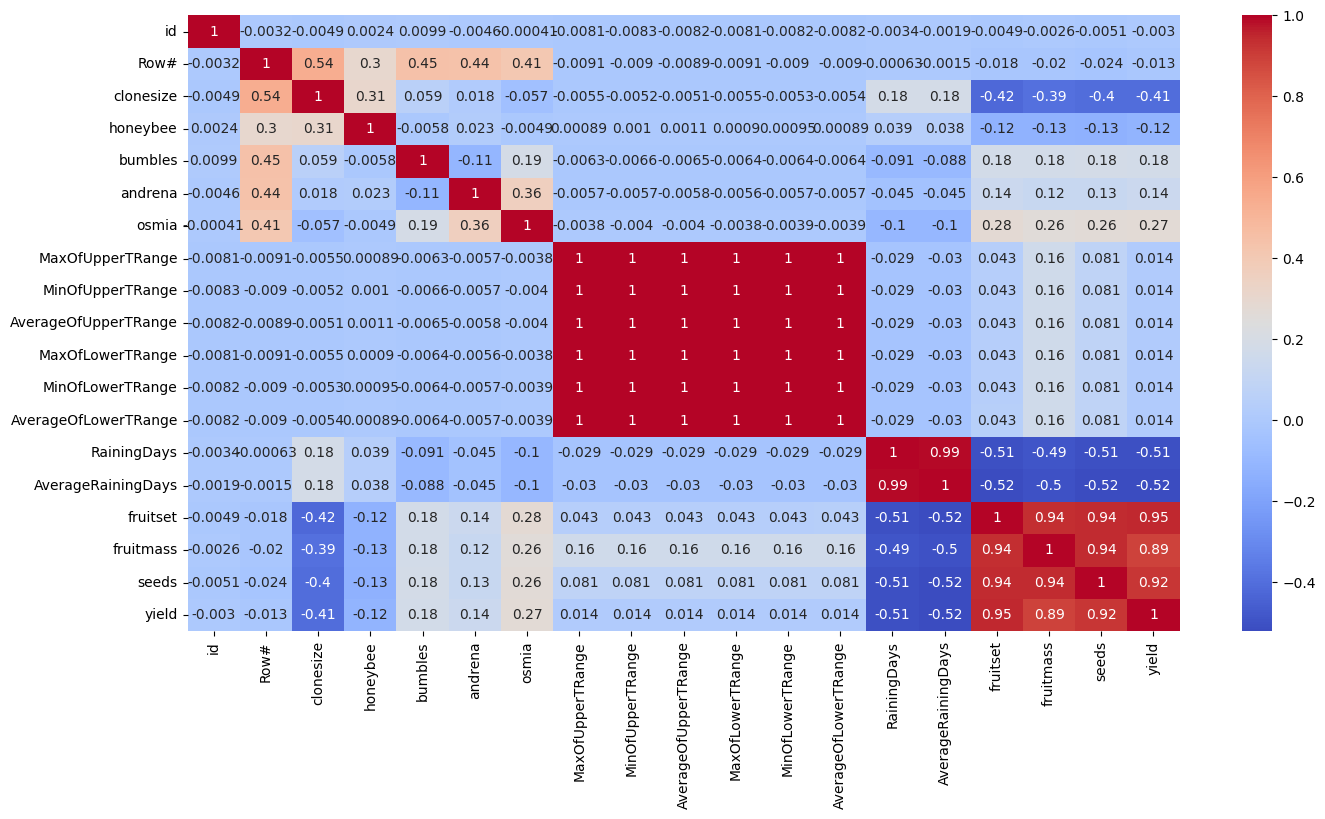

In [3]:
plotfig(train)

In [4]:
ids = test['id']
X_test= test

In [5]:
#HISTOGRAM - To analyse which features have a normal distribution by observing the Bell curves

def plothist(series):
    plt.hist(series, bins=20, rwidth=0.8)
    plt.xlabel('')
    plt.ylabel('Count');
    plt.show()

**Outlier Removal via Inter Quartile Method**

In [6]:

lower = train['seeds'].quantile(0.25)
upper = train['seeds'].quantile(0.75)
IQR = upper-lower
l_bound = lower - 1.5 * IQR
u_bound = upper + 1.5 * IQR
train = train[(train['seeds'] >= l_bound) & (train['seeds'] <= u_bound)]
targets = train['yield']
train = train.drop(columns=['yield'])

Checking for null values ( Since neither train nor test have null values , we dont need to fill null values)

In [7]:
train.columns[train.isnull().any()],test.columns[train.isnull().any()]

(Index([], dtype='object'), Index([], dtype='object'))

In [8]:
categorical_cols = train.select_dtypes(include='object').columns
categorical_cols , train.dtypes.value_counts()

(Index([], dtype='object'),
 float64    17
 int64       1
 Name: count, dtype: int64)

**NO ONE HOT ENCODING REQUIRED **

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train, targets, test_size=0.2, random_state=42)

In [10]:
#preprocessing data using a scaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test= scaler.transform(X_test)

**2 REGRESSION MODELS WERE EXPERIMENTED WITH **

* Using an XGBRegressor() with hyperparameter turning using GridSearchCV
* Using xgb DMatrix
  
  

In [11]:
#model 1
param_grid ={
        "n_estimators":[100,300],
        "max_depth":[3,5],
        "learning_rate":[0.05,0.1,0.15],
        #"subsample":[0.8,1.0],
        #"alpha":[0,1],
        #"gamma":[0,0.1],
}
grid = GridSearchCV(estimator=XGBRegressor(), param_grid = param_grid,cv=5,scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)
grid.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}

In [12]:
model=xgb.XGBRegressor(objective='reg:absoluteerror',learning_rate=0.05,max_depth=5,n_estimators=100,random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
mean_absolute_error(y_val,y_pred)

237.12288438852462

In [13]:
#model 2

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val)
params = {
        'objective': 'reg:absoluteerror', # or 'binary:logistic' for classification
        'eval_metric': 'mae', # or 'logloss' for classification
        'learning_rate': 0.15,
        'max_depth': 3,
}

In [14]:
model = xgb.train(params, dtrain, num_boost_round=300)
y_pred = model.predict(dtest)

In [15]:
mean_absolute_error(y_val,y_pred)

235.83988160085892

**The xgb DMatrix method has shown better results and the final predictions were based on the same**

In [16]:
test_pred=model.predict(xgb.DMatrix(X_test))

In [17]:
output = pd.DataFrame({'id': ids,
                       'yield': test_pred})
output.to_csv('submission.csv', index=False)

print("done")

done
